0.000801776321676755


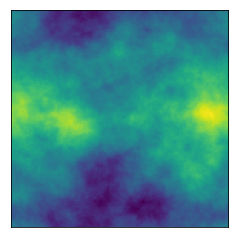

In [208]:
from __future__ import division
import math
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors


L = 3 #Length
N = 512 #Number of pixels
l0 = 0.01
L0 = 50
wvl = 500e-9
wvn = 2*np.pi / wvl
dz = 1000
fm = 5.92/l0
f0 = 2*np.pi / L0
cn2 = 1e-14
dx = L / N 
df = 2*np.pi / (N*dx)


#Scalar frequency grid
#fx = np.arange(-N/2.0, N/2.0) * df
#fx, fy = np.meshgrid(fx, -1*fx)
#f = np.sqrt( (fx**2) + (fy**2) )

f = np.zeros((N,N))
xf = np.fft.fftfreq(N,dx)
xf = np.fft.fftshift(xf)
yf = np.fft.fftfreq(N,dx)
yf = np.fft.fftshift(yf)
for i in range(0,N):
        for j in range(0,N):
            f[i,j] = np.sqrt(xf[i]**2 + yf[j]**2)
df = xf[2] - xf[1]

#Power Density
PDS = np.zeros((N,N))
#PDS = 0.033*cn2*np.exp( - (f/fm)**2  ) / np.power( (f**2 + f0**2), (11/3), ) #Blury
kl = 3.3/l0
#PDS = 0.033*cn2*(1.0 + 1.802*(f/kl) - 0.254*(f/kl) ** (2*7.0/12.0))*np.exp(1-(f/kl)**2)*(f**2+1/(l0**2))**(11/6) #Static-esk
PDS = 0.033*cn2*(f**2 + 1/(L0**2))**(-11/6) * np.exp(-(f/kl)**2)*(1 + 1.802*(f/kl) - 0.254*(f/kl)**(7/6)) #WORKS REALLY WELL

#PDS[int(N/2),int(N/2)] = 0.0

#Random array generation
cn = np.random.randn(N,N) + 1j*np.random.randn(N,N)


#Thing to inverse
cn = cn * np.sqrt(PDS*dz*2*np.pi) * (2*np.pi*wvn / (N*df) )


phz_tmp = np.fft.ifftn(np.fft.fftshift(cn))
result = np.real(phz_tmp)
print(np.amax(result))
plt.figure()
im = plt.imshow( result, cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)
#Generates a phase screen with qualitiy depending on the power spectrum used

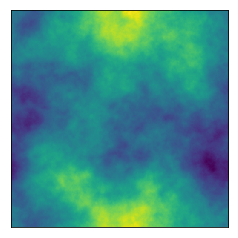

In [234]:
def freqRanges(N, L):
    dx = L/N
    xf = np.fft.fftfreq(N,dx)
    xf = np.fft.fftshift(xf)
    yf = np.fft.fftfreq(N,dx)
    yf = np.fft.fftshift(yf)
    return xf, yf

def freq(N, L,):
    fRx, fRy = freqRanges(N, L)
    for i in range(0,N):
        for j in range(0,N):
            f[i,j] = np.sqrt(fRx[i]**2 + fRy[j]**2)
    df = fRx[2] - fRx[1]
    return f, df

def randCompGaussian(N):
    return np.random.randn(N,N) + 1j*np.random.randn(N,N)

def refractionPertubation(f, df, dz, cn2, L0, kl, wvn, N):
    PDS = 0.033*cn2*(f**2 + 1/(L0**2))**(-11/6) * np.exp(-(f/kl)**2)*(1 + 1.802*(f/kl) - 0.254*(f/kl)**(7/6)) #WORKS REALLY WELL
    return np.sqrt(PDS*dz*2*np.pi) * (2*np.pi*wvn / (N*df) )
    
def phaseScreenGenInd(f, df, dz,cn2, L0, kl, wvn, N):
    PDS = 0.033*cn2*(f**2 + 1/(L0**2))**(-11/6) * np.exp(-(f/kl)**2)*(1 + 1.802*(f/kl) - 0.254*(f/kl)**(7/6)) #WORKS REALLY WELL
    cn = randCompGaussian(N)
    Gam = np.sqrt(PDS*dz*2*np.pi) * (2*np.pi*wvn / (N*df) )
    return np.fft.ifftn(np.fft.fftshift(Gam * cn))

def phaseScreenGen(f, df, dz, cn2, L0, kl, wvn, N, Gam):
    cn = randCompGaussian(N)
    return np.fft.ifftn(np.fft.fftshift(Gam * cn))
    
Freq = freq(512, 3)

PRI = refractionPertubation(f, df, dz, cn2, L0, kl, wvn, N)
phase0 = phaseScreenGen(Freq[0], Freq[1], dz, cn2, L0, 3.3/l0, wvn, N, PRI)
plt.figure()
im = plt.imshow( np.real(phase0), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

FROZEN METHOD

In [228]:
def phaseStackGenFroz(N, stackN, L, dz, cn2, L0, kl, wnv):
    Freq = freq(N, L)
    PRI = refractionPertubation(Freq[0], Freq[1], dz, cn2, L0, kl, wvn, N)
    stack = np.zeros((N,N,stackN), dtype = 'complex128')
    stack[:,:,0] = phaseScreenGen2(f, df, dz, cn2, L0, kl, wvn, N, PRI)
    for i in range(stackN):
        stack[:,:,i] = phaseScreenGen2(f, df, dz, cn2, L0, kl, wvn, N, PRI)
    return stack

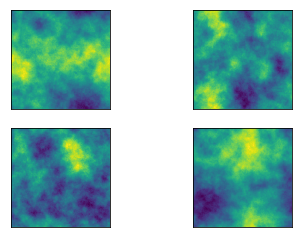

In [229]:
TESTSTACKF = phaseStackGenFroz(512, 5, 3, 100, 1e-15, 50, 3.3/0.01, 2*np.pi/500e-9)

plt.figure()
ax = plt.subplot(221)
im = plt.imshow(np.real(TESTSTACKF[:,:,0]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)
                
ax = plt.subplot(222)
im = plt.imshow( np.real(TESTSTACKF[:,:,1]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

ax = plt.subplot(223)
im = plt.imshow( np.real(TESTSTACKF[:,:,2]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

ax = plt.subplot(224)
im = plt.imshow( np.real(TESTSTACKF[:,:,3]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

AUTO REGRESSION METHOD

0.15692788905839894


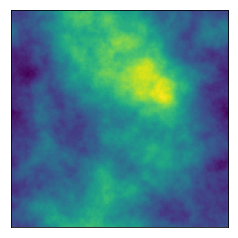

In [230]:
alpha = (np.zeros((N,N), dtype = 'complex128') + 1) * np.random.random()
print(np.real(alpha[1,1]))
windAngle = np.random.random()*2*np.pi
vx = np.cos(windAngle)
vy = np.sin(windAngle)

xf = np.fft.fftfreq(N,dx)
xf = np.fft.fftshift(xf)
yf = np.fft.fftfreq(N,dx)
yf = np.fft.fftshift(yf)

for i in range(N):
    for j in range(N):
        alpha[i,j] = alpha[i,j] * np.exp(-1j*2*np.pi*Freq[1]*(xf[i]*vx + yf[j]*vy))
#print(alpha)
interior = alpha*np.fft.fftn(phase0) + np.fft.fftshift( np.sqrt(1 - abs(alpha**2))*PRI*randCompGaussian(N) )
phase1 = np.fft.ifftn(interior)
plt.figure()
im = plt.imshow( np.real(phase1), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

In [231]:
def alphaWind(modA, angleA, N, L):
    alpha = (np.zeros((N,N), dtype = 'complex128') + 1) * modA
    vx = np.cos(angleA)
    vy = np.sin(angleA)
    fRx, fRy = freqRanges(N, L)
    df = fRx[0]-fRx[1]
    for i in range(N):
        for j in range(N):
            alpha[i,j] = alpha[i,j] * np.exp(-1j*2*np.pi*df*(xf[i]*vx + yf[j]*vy))
    return alpha

def autoRegressionPhase(alpha, phase0, PRI, N):
    interior = alpha*np.fft.fftn(phase0) + np.fft.fftshift( np.sqrt(1 - abs(alpha**2))*PRI*randCompGaussian(N) )
    phase1 = np.fft.ifftn(interior)
    return phase1

def phaseStackGenAuto(N, stackN, L, modA, angleA, dz, cn2, L0, kl, wnv):
    Freq = freq(N, L)
    PRI = refractionPertubation(Freq[0], Freq[1], dz, cn2, L0, kl, wvn, N)
    alpha = alphaWind(modA, angleA, N, L)
    stack = np.zeros((N,N,stackN), dtype = 'complex128')
    stack[:,:,0] = phaseScreenGen(f, df, dz, cn2, L0, kl, wvn, N, PRI)
    for i in range(stackN - 1):
        stack[:,:, i + 1] = autoRegressionPhase(alpha, stack[:,:,i], PRI, N)
    return stack

TESTSTACKAR = phaseStackGenAuto(512, 5, 3, 0.01, np.random.random()*2*np.pi, 100, 1e-15, 50, 3.3/0.01, 2*np.pi/500e-9)

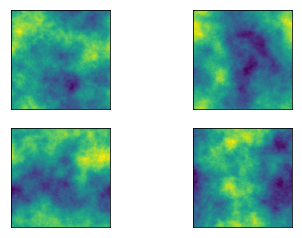

In [232]:
plt.figure()
ax = plt.subplot(221)
im = plt.imshow(np.real(TESTSTACKAR[:,:,0]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)
                
ax = plt.subplot(222)
im = plt.imshow( np.real(TESTSTACKAR[:,:,1]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

ax = plt.subplot(223)
im = plt.imshow( np.real(TESTSTACKAR[:,:,2]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

ax = plt.subplot(224)
im = plt.imshow( np.real(TESTSTACKAR[:,:,3]), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)


RIBBON METHOD

In [214]:
def freqRec(Nx, Ny, L):
    dx = L/Nx
    f = np.zeros((Nx,Ny))
    xf = np.fft.fftfreq(Nx,dx)
    xf = np.fft.fftshift(xf)
    yf = np.fft.fftfreq(Ny,dx)
    yf = np.fft.fftshift(yf)
    for i in range(0,Nx):
        for j in range(0,Ny):
            f[i,j] = np.sqrt(xf[i]**2 + yf[j]**2)
    df = xf[2] - xf[1]
    return f, df

def randCompGaussianRec(Nx, Ny):
    return np.random.randn(Nx,Ny) + 1j*np.random.randn(Nx,Ny)

def refractionPertubationRec(f, df, dz, cn2, L0, kl, wvn, Nx, Ny):
    PDS = 0.033*cn2*(f**2 + 1/(L0**2))**(-11/6) * np.exp(-(f/kl)**2)*(1 + 1.802*(f/kl) - 0.254*(f/kl)**(7/6)) #WORKS REALLY WELL
    return np.sqrt(PDS*dz*2*np.pi) * (2*np.pi*wvn / (np.sqrt(Nx**2)*df) )
    
def phaseScreenGenRec(f, df, dz,cn2, L0, kl, wvn, Nx, Ny):
    PDS = 0.033*cn2*(f**2 + 1/(L0**2))**(-11/6) * np.exp(-(f/kl)**2)*(1 + 1.802*(f/kl) - 0.254*(f/kl)**(7/6)) #WORKS REALLY WELL
    cn = randCompGaussianRec(Nx, Ny)
    Gam = np.sqrt(PDS*dz*2*np.pi) * (2*np.pi*wvn / (np.sqrt(Nx**2)*df) )
    return np.fft.ifftn(np.fft.fftshift(Gam * cn))

def phaseScreenGen2Rec(Nx, Ny, Gam):
    cn = randCompGaussianRec(Nx, Ny)
    return np.fft.ifftn(np.fft.fftshift(Gam * cn))

(0.0011165472761269276+0.00029517906375905j)


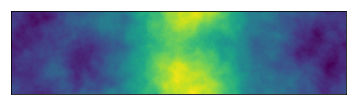

In [215]:
R = 4
FreqRec = freqRec(N, R*N, L)
GamRec = refractionPertubationRec(FreqRec[0], FreqRec[1], dz, cn2, L0, kl, wvn, N, R*N)
phaseRec1 =  phaseScreenGen2Rec(N, R*N, GamRec)

print(np.amax(phaseRec1))
plt.figure()
im = plt.imshow( np.real(phaseRec1), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

(0.0014488722865984981-0.0009706115623373179j)


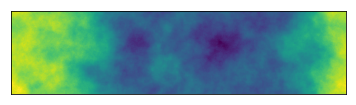

In [216]:
phaseRec2 = phaseScreenGen2Rec(N, R*N, GamRec)
print(np.amax(phaseRec2))
plt.figure()
im = plt.imshow( np.real(phaseRec2), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)

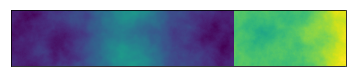

In [218]:
phaseRibbon = np.zeros((N,(2*R - 2)*N), dtype = 'complex128')
phaseRibbon[:,:int(N*R/2)] = phaseRec1[:,:int(N*R/2)]
phaseRibbon[:,2*int(N*R/2):] = phaseRec2[:,int(N*R/2):]
for i in range(2*N):
    phaseRibbon[:,int(N*R/2)+i] = phaseRec1[:,int(N*R/2)+i]*np.cos(np.pi/2*(i/2*N)) + phaseRec2[:,i]*np.sin(np.pi/2*(i/2*N))
    
plt.figure()
im = plt.imshow( np.real(phaseRibbon), cmap = cm.viridis)
im.axes.get_xaxis().set_visible(False)
im.axes.get_yaxis().set_visible(False)